In [1]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt




In [2]:
pd.set_option("display.max_rows", None) 
pd.set_option("display.max_columns", None)

In [6]:
df = pd.read_json('/Users/barry/CodeAcademy/Sea_watch/sample_traces/2022_09_407637.json')

In [4]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL

class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.__func__, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'


35.474258
12.600117
plane: 407637
take_off: 2022-09-01 00:00:00


/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


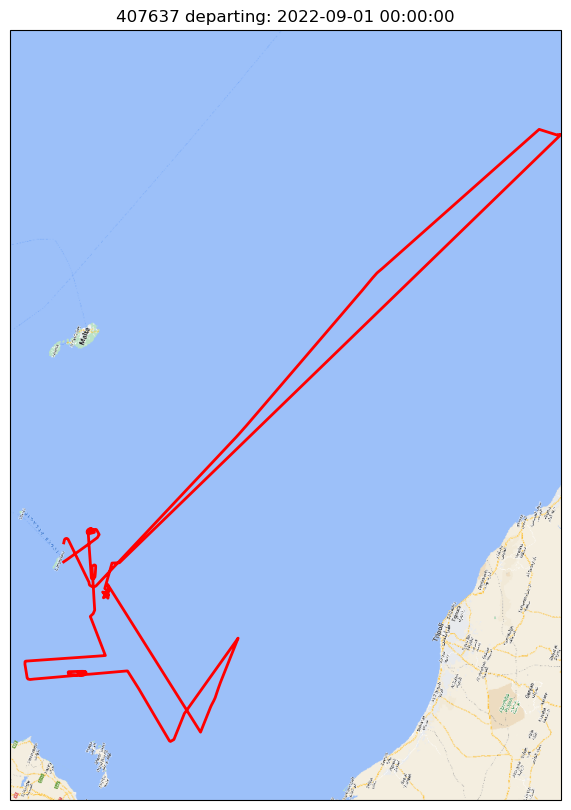

In [7]:
def route_maker(df):
    icao = df.icao.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    timeline = []
    latitude = []
    longitude = []
    altitude = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
    print(latitude[0])
    print(longitude[0])
    print(f'plane: {icao}\ntake_off: {time_stamp}')
    flight_info = zip(timeline, latitude, longitude, altitude)

    # Initialize our Google Maps tiles
    actual_tiler = cimgt.GoogleTiles()
    imagery = CachedTiler(actual_tiler)


    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(projection=ccrs.LambertConformal())
    plt.title(f'{icao} departing: {time_stamp}')

    # Set the boundaries around the map
    ax.set_extent([ 
        max(longitude), min(longitude),
        min(latitude), max(latitude)
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)

    # Draw the path of the fligt
    track = sgeom.LineString(zip(longitude,latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)    

route_maker(df)

